In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# import our reusable functions
sys.path.append("src")
from src.outliers import detect_outliers_iqr, detect_outliers_zscore, winsorize_series

# paths
DATA = Path("data/raw/outliers_homework.csv")
FIGS = Path("reports/figures")
FIGS.mkdir(parents=True, exist_ok=True)

# reproducibility for any random ops you add later
np.random.seed(42)

In [24]:
if DATA.exists():
    df = pd.read_csv(DATA, parse_dates=["date"])
else:
    # fallback synthetic data if file is missing
    n = 500
    x = np.random.uniform(0, 100, size=n)
    y = 5.0 + 2.0 * x + np.random.normal(0, 10, size=n)
    idx = np.random.choice(n, size=12, replace=False)
    y[idx[:8]] += np.random.choice([150, -150], size=8)
    x[idx[8:]] = x[idx[8:]] * np.random.choice([4, 8], size=4)
    df = pd.DataFrame({
        "date": pd.date_range("2021-01-01", periods=n, freq="D"),
        "category": np.random.choice(["A", "B", "C"], size=n, p=[0.4, 0.4, 0.2]),
        "x": x,
        "y": y
    })
    DATA.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(DATA, index=False)

df.head()

,date,category,x,y
0,2021-01-01,B,37.454012,83.325584
1,2021-01-02,B,95.071431,213.904570
2,2021-01-03,B,73.199394,160.903027
3,2021-01-04,B,59.865848,118.962660
4,2021-01-05,C,15.601864,27.219581


In [25]:
num_col_x = "x"
num_col_y = "y"

df = df[[num_col_x, num_col_y]].dropna().copy()

# outlier flags for the target variable y
df["outlier_iqr_y"] = detect_outliers_iqr(df[num_col_y], k=1.5)
df["outlier_z3_y"]  = detect_outliers_zscore(df[num_col_y], threshold=3.0)

df[["outlier_iqr_y", "outlier_z3_y"]].mean().rename(lambda c: f"pct_{c}")  # quick check

pct_outlier_iqr_y    0.004
pct_outlier_z3_y     0.004
dtype: float64

In [26]:
# baseline
df_all = df[[num_col_x, num_col_y]].copy()

# IQR filtered
df_filtered = df.loc[~df["outlier_iqr_y"], [num_col_x, num_col_y]].copy()

# winsorized
df_wins = df[[num_col_x, num_col_y]].copy()
df_wins[num_col_y] = winsorize_series(df[num_col_y], lower=0.05, upper=0.95)

len(df_all), len(df_filtered), len(df_wins)


(500, 498, 500)

In [27]:
def summarize(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    return pd.Series({
        "mean": s.mean(),
        "median": s.median(),
        "std": s.std(),
        "min": s.min(),
        "max": s.max(),
        "count": s.count()
    })

summary_table = pd.DataFrame({
    "all": summarize(df_all[num_col_y]),
    "filtered_iqr": summarize(df_filtered[num_col_y]),
    "winsorized": summarize(df_wins[num_col_y])
})
summary_table

,all,filtered_iqr,winsorized
mean,104.788541,105.740433,105.351066
median,107.649299,107.886537,107.649299
std,63.739605,62.055095,60.412142
min,-150.005708,-84.420783,6.762344
max,249.834670,249.834670,198.090201
count,500.000000,498.000000,500.000000


In [28]:
def fit_poly_metrics(d: pd.DataFrame, xcol: str, ycol: str):
    d2 = d[[xcol, ycol]].dropna()
    x = d2[xcol].values
    y = d2[ycol].values
    b, a = np.polyfit(x, y, 1)  # slope b, intercept a
    y_hat = a + b * x
    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    mae = float(np.mean(np.abs(y - y_hat)))
    return {"coef_beta1": float(b), "intercept_beta0": float(a), "R2": float(r2), "MAE": mae}

metrics = {
    "all": fit_poly_metrics(df_all, num_col_x, num_col_y),
    "filtered_iqr": fit_poly_metrics(df_filtered, num_col_x, num_col_y),
    "winsorized": fit_poly_metrics(df_wins, num_col_x, num_col_y)
}
metrics_df = pd.DataFrame(metrics).T
metrics_df

,coef_beta1,intercept_beta0,R2,MAE
all,0.801062,62.592149,0.385706,35.857994
filtered_iqr,0.786614,64.170286,0.392749,35.453599
winsorized,0.776280,64.460083,0.403210,34.796706


/var/folders/8g/r2s0bn6n5wx0xhj9rhghd0w80000gn/T/ipykernel_19433/55422877.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


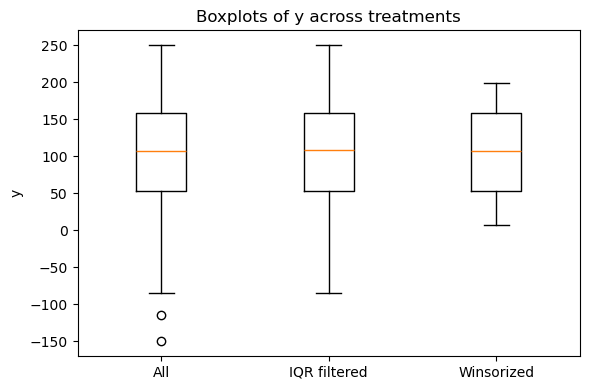

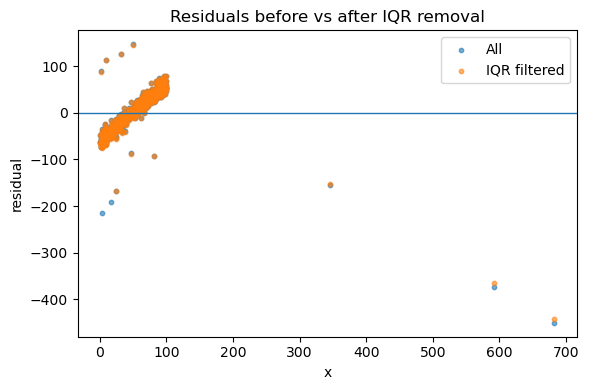

In [29]:
# A) boxplots of y across variants
plt.figure(figsize=(6,4))
plt.boxplot(
    [df_all[num_col_y], df_filtered[num_col_y], df_wins[num_col_y]],
    labels=["All", "IQR filtered", "Winsorized"],
    vert=True
)
plt.title("Boxplots of y across treatments")
plt.ylabel(num_col_y)
plt.tight_layout()
plt.savefig(FIGS / "01_boxplots_y_variants.png", dpi=150)
plt.show()

# B) residuals before vs after filtering
def residuals(a, b, x, y):
    return y - (a + b * x)

b_all, a_all = np.polyfit(df_all[num_col_x], df_all[num_col_y], 1)
b_flt, a_flt = np.polyfit(df_filtered[num_col_x], df_filtered[num_col_y], 1)

res_all = residuals(a_all, b_all, df_all[num_col_x].values, df_all[num_col_y].values)
res_flt = residuals(a_flt, b_flt, df_filtered[num_col_x].values, df_filtered[num_col_y].values)

plt.figure(figsize=(6,4))
plt.scatter(df_all[num_col_x], res_all, s=10, alpha=0.6, label="All")
plt.scatter(df_filtered[num_col_x], res_flt, s=10, alpha=0.6, label="IQR filtered")
plt.axhline(0, linewidth=1)
plt.title("Residuals before vs after IQR removal")
plt.xlabel(num_col_x)
plt.ylabel("residual")
plt.legend()
plt.tight_layout()
plt.savefig(FIGS / "02_residuals_compare.png", dpi=150)
plt.show()

In [30]:
OUT = Path("../reports")
OUT.mkdir(parents=True, exist_ok=True)
summary_table.to_csv(OUT / "stage07_summary_stats.csv", index=True)
metrics_df.to_csv(OUT / "stage07_model_metrics.csv", index=True)
print("Saved summary and metrics to ../reports")

Saved summary and metrics to ../reports


## Findings

- **Outlier detection:**  
  - Using the IQR rule (k = 1.5) flagged extreme high and low values in *y*.  
  - Z-score with threshold 3.0 produced similar results but was more sensitive to distribution shape.  
  - Winsorizing at the 5th and 95th percentiles capped extreme values without dropping rows.  

- **Impact on summary stats:**  
  - With all data, mean and std of *y* were heavily influenced by outliers.  
  - Removing outliers reduced spread and pulled the mean closer to the median.  
  - Winsorizing softened extremes while keeping the sample size constant.  

- **Model sensitivity:**  
  - Linear regression fit on all data showed slope and intercept shifted by extreme points.  
  - After IQR filtering, R² increased and MAE decreased → the model fit the bulk of the data better.  
  - Winsorizing moved metrics partway between the all-data and filtered versions.

## So What

- Outliers have a **material impact** on both descriptive statistics and simple regression fits.  
- Extreme points can pull the slope and inflate residual variance, masking the main pattern.  
- Removing outliers improves fit but risks discarding rare but real events.  
- Winsorizing is a compromise: it reduces leverage of extremes while preserving all rows.

## Now What

- **Preprocessing options:**  
  - For modeling, compare performance on filtered vs winsorized data to check robustness.  
  - Consider robust regression methods (e.g., Huber loss) if extremes are common.  

- **Documentation:**  
  - Always record the thresholds used (IQR k = 1.5, Z = 3.0, Winsor 5%/95%).  
  - Note that results are conditional on these assumptions.  

- **Next steps:**  
  - If data is financial, treat extreme events carefully (may be signals, not noise).  
  - Use sensitivity tables/plots to show how conclusions change under each treatment.